# Individiual Submission: Tin Jing Lun Javier from SDAE
## Group Name: StillPondTeam

### **Overall Approach:**

The primary objective of this project is to develop and evaluate Reinforcement Learning (RL) agents capable of solving the classic CartPole-v1 control problem, as defined by the Gymnasium environment. The specific goal is to train agents that can consistently achieve an average cumulative reward greater than 195 over 100 evaluation episodes.

To address this challenge, three distinct RL algorithms were implemented and compared:

1.  **Q-Learning:** A tabular, model-free, off-policy Temporal Difference (TD) method. Due to the continuous state space of CartPole, this approach required **state discretization**, where the four observation dimensions (cart position, cart velocity, pole angle, pole angular velocity) were mapped into a finite number of bins to create a discrete state representation usable by a Q-table.
2.  **Monte Carlo (MC) Control:** A tabular, model-free method that learns from complete episodes. Similar to Q-Learning, **state discretization** was necessary. The implementation used a First-Visit MC approach, averaging returns for state-action pairs after each episode.
3.  **Deep Q-Network (DQN):** A function approximation method using a neural network to estimate Q-values directly from the continuous state space, thus avoiding explicit discretization. This implementation incorporated essential techniques for stability and performance, namely **Experience Replay** (using a replay buffer) and a **Target Network**.

The project followed a **comparative and iterative methodology**:

*   **Initial Implementation ("Original"):** Basic versions of Q-Learning, MC, and DQN were first implemented with standard hyperparameters and simpler settings (e.g., fewer discretization bins for QL/MC, standard DQN update).
*   **Improvement Phase ("Improved"):** Based on the initial results and known limitations of these basic implementations (e.g., coarse discretization for tabular methods, overestimation bias in standard DQN), improved versions were developed. Key improvements included:
    *   Significantly increasing the number of **discretization bins** and **training episodes** for Q-Learning and Monte Carlo to enhance state resolution and allow sufficient exploration.
    *   Implementing **Double DQN (DDQN)** to mitigate Q-value overestimation and **tuning hyperparameters** (learning rate, batch size, target update frequency) for the DQN agent, along with increasing training episodes.
*   **Evaluation:** Both the "Original" and "Improved" configurations for each agent were systematically trained and then evaluated over 100 episodes to measure their average cumulative reward. Training time and stability were considered as secondary metrics.

This notebook presents the implementation details, training processes, evaluation results (including performance plots), and rendered visualizations, allowing for a direct comparison of the effectiveness of these different algorithms and the impact of the implemented improvements in tackling the CartPole challenge.

### 0. Setup and Dependencies

This initial section handles the necessary setup for the project. It includes:
*   Importing required libraries: `gymnasium` for the environment, `torch` for neural networks (DQN), `numpy` for numerical operations, `matplotlib` for plotting, `pandas` for results display, and helpers like `random`, `time`, `os`, `base64`, and `IPython.display` for video rendering and notebook interaction.
*   Setting global random seeds (`SEED=42`) for `random`, `numpy`, and `torch` to ensure reproducibility of results.
*   Selecting the computation device (`cpu` or `cuda` if available) for PyTorch operations.
*   Defining a helper function `show_video` to render and display the recorded simulation videos within the notebook.



## Environment Information

All experiments and code development for this assignment were conducted on a local machine with the following specifications:

*   Operating System: Windows 11 Home, Version 24H2, OS build 26100.3476
*   Processor (CPU): 13th Gen Intel(R) Core(TM) i7-13700H @ 2.40 GHz
*   RAM: 32.0 GB (31.7 GB usable)
*   GPU: None (CPU only)
*   Key Library Versions:
    *   Pandas: 2.0.3
    *   Gymnasium: 1.1.1
    *   Torch: 2.6.0+cpu
    *   NumPy: 1.26.4
    *   Matplotlib: 3.7.2

The performance of the RL agents may vary if the notebook is run on a different environment (e.g., Google Colab) due to variations in hardware and software configurations.  This notebook is designed to function correctly within the specified environment.

In [2]:
# -*- coding: utf-8 -*-
"""
SC3000/CZ3005 Assignment 1: CartPole RL Agents Comparison (Original vs Improved)

This notebook implements and compares ORIGINAL and IMPROVED versions of
Q-Learning, Monte Carlo, and DQN agents for CartPole-v1.

Team Members:
- [Javier Tin Jing Lun/U2310906E]
"""

# ==============================================================================
# 0. Setup and Dependencies (For Windows-based System)
# ==============================================================================
#!pip install gymnasium[classic_control] pygame torch numpy matplotlib ipython Pillow
#!pip install "gymnasium[other]
import pandas as pd # Make sure pandas is imported
from IPython import display as ipythondisplay # Imports the MODULE as ipythondisplay
from IPython.display import display, HTML     # Imports the FUNCTION display and CLASS HTML directly
from IPython.display import clear_output

import gymnasium as gym
from gymnasium.wrappers import RecordVideo

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import math
import time
import collections
import os
import base64


print(f"Pandas version: {pd.__version__}")
print(f"Gymnasium version: {gym.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")


# Set random seeds for reproducibility
SEED = 42 # Choose a number

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Helper function for Colab video rendering
def show_video(video_path_base="./video"):
    """Shows the most recent mp4 video found in the video directory."""
    mp4_files = sorted([f for f in os.listdir(video_path_base) if f.endswith(".mp4")], reverse=True)
    if not mp4_files:
        print(f"Could not find video files in {video_path_base}")
        return
    mp4 = os.path.join(video_path_base, mp4_files[0])
    video = open(mp4, 'rb').read()
    encoded = base64.b64encode(video)
    display(HTML(data=f'''
    <video width="360" height="auto" controls>
        <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4">
    </video>'''))

Pandas version: 2.0.3
Gymnasium version: 1.1.1
Torch version: 2.6.0+cpu
NumPy version: 1.26.4
Matplotlib version: 3.7.2
Using device: cpu


### 1. Environment Setup & Discretization

This section prepares the CartPole environment and sets up parameters for state discretization needed by the tabular RL methods (Q-Learning, Monte Carlo).
*   The `CartPole-v1` environment from Gymnasium is instantiated to check its action and observation spaces.
*   Discretization parameters are defined:
    *   `N_BINS_ORIG` and `N_BINS_IMP`: Specify the number of bins for the original and improved tabular agents, respectively. More bins allow for finer state resolution.
    *   `BOUNDS`: Defines the practical upper and lower limits for each observation dimension used for scaling during discretization. Limits for velocity and angular velocity are chosen empirically as the environment defines them as infinite.
*   The `discretize_state` function implements the logic to convert a continuous observation vector into a tuple of discrete bin indices based on the defined bins and bounds. A test case demonstrates its usage.

In [2]:

# ==============================================================================
# 1. Environment Setup & Discretization (Define BOTH bin sets)
# ==============================================================================
env_name = "CartPole-v1"
try:
    env_test = gym.make(env_name)
    print(f"Action space: {env_test.action_space}")
    print(f"Observation space: {env_test.observation_space}")
    print(f"Obs low: {env_test.observation_space.low}")
    print(f"Obs high: {env_test.observation_space.high}")
    env_test.close()
except Exception as e:
    print(f"Error creating environment: {e}")

# --- Discretization Parameters ---
# Original settings
N_BINS_ORIG = [10, 10, 10, 10]
print(f"Using Original Bins: {N_BINS_ORIG}")
# Improved settings
N_BINS_IMP = [20, 20, 20, 20]
print(f"Using Improved Bins: {N_BINS_IMP}")

# Bounds (remain the same)
POS_BOUNDS = [-2.4, 2.4]
VEL_BOUNDS = [-3.0, 3.0]
ANG_BOUNDS = [-0.418, 0.418]
ANG_VEL_BOUNDS = [-3.0, 3.0]
BOUNDS = [POS_BOUNDS, VEL_BOUNDS, ANG_BOUNDS, ANG_VEL_BOUNDS]

def discretize_state(observation, n_bins, bounds):
    """Converts a continuous observation into a discrete state tuple."""
    discrete_state = []
    for i, obs_val in enumerate(observation):
        low, high = bounds[i]
        num_bins_dim = n_bins[i]
        # Clip the observation to be within the defined bounds
        clipped_obs = np.clip(obs_val, low, high)
        # Scale the observation to [0, num_bins_dim - 1]
        bin_index = int(((clipped_obs - low) / (high - low)) * (num_bins_dim - 1))
        # Ensure bin_index is within [0, num_bins_dim - 1] even with floating point inaccuracies
        bin_index = max(0, min(num_bins_dim - 1, bin_index))
        discrete_state.append(bin_index)
    return tuple(discrete_state)


# Test discretization
test_env = gym.make(env_name)
test_obs, _ = test_env.reset()
discrete_s = discretize_state(test_obs, N_BINS_ORIG, BOUNDS)
print(f"Sample Observation: {test_obs}")
print(f"Discretized State: {discrete_s}")
test_env.close()





Action space: Discrete(2)
Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Obs low: [-4.8               -inf -0.41887903        -inf]
Obs high: [4.8               inf 0.41887903        inf]
Using Original Bins: [10, 10, 10, 10]
Using Improved Bins: [20, 20, 20, 20]
Sample Observation: [-0.02069955 -0.01756352  0.02875321  0.03908825]
Discretized State: (4, 4, 4, 4)


### 2.1 Q-Learning Agent Implementation

Below is the implementation of the `QLearningAgent` class, representing a standard Q-Learning algorithm for discrete state and action spaces.


In [3]:
# ==============================================================================
# 2. Agent Implementations (Modify DQN Agent slightly)
# ==============================================================================

# --- 2.1 QLearningAgent Class 
class QLearningAgent:
    def __init__(self, n_states_dims, n_actions, learning_rate=0.1, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995,
                 n_bins=N_BINS_ORIG, bounds=BOUNDS):
        self.n_actions = n_actions
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.n_bins = n_bins
        self.bounds = bounds

        # Initialize Q-table with zeros
        q_table_dims = tuple(n_bins + [n_actions])
        self.q_table = np.zeros(q_table_dims)
        print(f"Initialized Q-Table with shape: {self.q_table.shape}")


    def discretize(self, observation):
        return discretize_state(observation, self.n_bins, self.bounds)

    def get_action(self, state_obs, explore=True):
        """Choose action using epsilon-greedy strategy."""
        discrete_state = self.discretize(state_obs)

        if explore and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1) # Explore
        else:
            return np.argmax(self.q_table[discrete_state]) # Exploit

    def learn(self, state_obs, action, reward, next_state_obs, terminated):
        """Update Q-table using the Q-learning rule."""
        discrete_state = self.discretize(state_obs)
        next_discrete_state = self.discretize(next_state_obs)

        # Q-learning update rule
        current_q = self.q_table[discrete_state + (action,)]
        if terminated:
            target_q = reward # No future reward if terminated
        else:
            max_next_q = np.max(self.q_table[next_discrete_state])
            target_q = reward + self.gamma * max_next_q

        # Update Q-value
        new_q = current_q + self.lr * (target_q - current_q)
        self.q_table[discrete_state + (action,)] = new_q

    def decay_epsilon(self):
        """Decay exploration rate."""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

*   **`__init__`:** Initializes the agent with hyperparameters (learning rate `alpha`, discount factor `gamma`, epsilon schedule parameters) and creates the Q-table as a NumPy array filled with zeros. The table dimensions are determined by the number of bins specified for each state dimension and the number of possible actions.
*   **`discretize`:** A helper method that calls the global `discretize_state` function.
*   **`get_action`:** Implements the epsilon-greedy policy. With probability epsilon, it selects a random action (exploration); otherwise, it selects the action with the highest Q-value for the current discretized state (exploitation) using `np.argmax`.
*   **`learn`:** Implements the core Q-learning update rule: `Q(s, a) <- Q(s, a) + alpha * [R + gamma * max_a'(Q(s', a')) - Q(s, a)]`. It calculates the TD target based on the reward and the maximum Q-value of the next state (unless the next state is terminal) and updates the Q-value for the experienced state-action pair.
*   **`decay_epsilon`:** Reduces the exploration rate `epsilon` multiplicatively according to the decay factor.

### 2.2 Monte Carlo Agent Implementation

This section defines the `MonteCarloAgent` class, implementing a First-Visit Monte Carlo control method for discrete state spaces.

In [4]:
# --- 2.2 Monte Carlo Agent ---
class MonteCarloAgent:
    def __init__(self, n_states_dims, n_actions, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995,
                 n_bins=N_BINS_ORIG, bounds=BOUNDS):
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.n_bins = n_bins
        self.bounds = bounds

        # Q-table and Returns tracking
        q_table_dims = tuple(n_bins + [n_actions])
        self.q_table = np.zeros(q_table_dims) # Initialize Q(s,a)
        self.returns_sum = np.zeros(q_table_dims) # Sum of returns for (s,a)
        self.returns_count = np.zeros(q_table_dims) # Count of visits for (s,a)

        print(f"Initialized MC Q-Table with shape: {self.q_table.shape}")


    def discretize(self, observation):
        return discretize_state(observation, self.n_bins, self.bounds)

    def get_action(self, state_obs, explore=True):
        """Choose action using epsilon-greedy strategy based on current Q-estimates."""
        discrete_state = self.discretize(state_obs)

        if explore and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1) # Explore
        else:
            # Check if all actions for this state have Q-value 0 (unexplored)
            if np.all(self.q_table[discrete_state] == 0):
                 return random.randint(0, self.n_actions - 1) # Explore if state is new
            return np.argmax(self.q_table[discrete_state]) # Exploit

    def learn(self, episode_history):
        """Update Q-table using First-Visit Monte Carlo."""
        G = 0 # Cumulative discounted return
        visited_state_action_pairs = set()

        # Iterate backwards through the episode (t = T-1, T-2, ..., 0)
        for t in range(len(episode_history) - 1, -1, -1):
            state_obs, action, reward = episode_history[t]
            discrete_state = self.discretize(state_obs)
            state_action_pair = discrete_state + (action,)

            # Calculate discounted return G = R_{t+1} + gamma * G_{t+1}
            G = reward + self.gamma * G

            # Check if this is the first visit to (state, action) in this episode
            if state_action_pair not in visited_state_action_pairs:
                self.returns_sum[state_action_pair] += G
                self.returns_count[state_action_pair] += 1
                # Update Q-value as the average of returns
                self.q_table[state_action_pair] = self.returns_sum[state_action_pair] / self.returns_count[state_action_pair]
                visited_state_action_pairs.add(state_action_pair)

    def decay_epsilon(self):
        """Decay exploration rate."""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

*   **`__init__`:** Initializes hyperparameters (gamma, epsilon schedule) and sets up arrays for the Q-table (`q_table`), the sum of returns (`returns_sum`), and the visit counts (`returns_count`) for each state-action pair, all sized according to the specified bins.
*   **`discretize`:** Calls the global `discretize_state` function.
*   **`get_action`:** Implements epsilon-greedy action selection. It includes a check to ensure exploration if a state has not been visited before (all Q-values are zero).
*   **`learn`:** Implements the First-Visit MC update. It takes a completed `episode_history` (list of state, action, reward tuples). It iterates backwards through the episode, calculating the discounted return `G` at each step. For the first time a state-action pair is encountered in the episode, it updates the `returns_sum` and `returns_count`, and recalculates the Q-value for that pair as the average of the observed returns.
*   **`decay_epsilon`:** Reduces the exploration rate `epsilon`.

### 2.3 Deep Q-Network (DQN) Agent Implementation

This section implements the DQN agent, which uses neural networks and does not require manual state discretization. It includes helper classes for the replay memory and the Q-network itself.

#### Replay Memory
The `ReplayMemory` class stores past transitions experienced by the agent.

In [5]:
# --- 2.3 DQN Agent (MODIFIED to support both standard and double DQN) ---

# Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = collections.deque([], maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """Save a transition."""
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """Sample a batch of transitions."""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

*   It uses a `collections.deque` with a fixed maximum capacity (`maxlen`) to store tuples of (state, action, reward, next_state, done).
*   The `push` method adds a new transition, automatically discarding the oldest one if the capacity is exceeded.
*   The `sample` method randomly selects a batch of transitions from the memory using `random.sample`, crucial for breaking correlations during training.

#### Q-Network Definition
The `QNetwork` class defines the neural network architecture used to approximate the Q-value function.

In [6]:
# Q-Network Definition
class QNetwork(nn.Module):
    def __init__(self, n_observations, n_actions, hidden_dim=128):
        super(QNetwork, self).__init__()
        # Reduced complexity slightly - CartPole often doesn't need huge networks
        self.layer1 = nn.Linear(n_observations, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, n_actions)

    def forward(self, x):
        # Ensure input is a float tensor
        if not isinstance(x, torch.Tensor):
             x = torch.tensor(x, dtype=torch.float32, device=device)
        elif x.dtype != torch.float32:
             x = x.to(dtype=torch.float32)

        x = x.to(device) # Move tensor to the correct device

        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

*   It inherits from `torch.nn.Module`.
*   The architecture is a simple Multi-Layer Perceptron (MLP) with two hidden layers (size `hidden_dim=128`) using ReLU activation functions.
*   The input layer takes the 4-dimensional state observation, and the output layer produces Q-values for each possible discrete action (2 actions for CartPole).
*   The `forward` method handles tensor conversion, device placement, and the pass through the network layers.

#### DQN Agent Class
The `DQNAgent` class orchestrates the DQN learning process, integrating the Q-network and replay memory. It supports both standard DQN and Double DQN (DDQN).

In [7]:
# Modified DQNAgent Class
class DQNAgent:
    def __init__(self, n_observations, n_actions, memory_size=10000, batch_size=32, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995,
                 learning_rate=1e-3, target_update_freq=10,
                 use_double_dqn=False): # <<< Added flag
        self.n_actions = n_actions
        self.memory = ReplayMemory(memory_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq
        self.use_double_dqn = use_double_dqn # <<< Store the flag
        if self.use_double_dqn:
            print("Initializing DQNAgent with Double DQN.")
        else:
            print("Initializing DQNAgent with standard DQN.")

        # ... (Network initialization, optimizer - use parameters passed in) ...
        self.policy_net = QNetwork(n_observations, n_actions).to(device)
        self.target_net = QNetwork(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=learning_rate, amsgrad=True)
        self.steps_done = 0


    def get_action(self, state_obs, explore=True):
        # ... (Keep as before) ...
        state_tensor = torch.tensor(state_obs, dtype=torch.float32, device=device).unsqueeze(0)
        if explore and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            with torch.no_grad():
                q_values = self.policy_net(state_tensor)
                action = q_values.max(1)[1].item()
                return action

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = tuple(zip(*transitions))

        state_batch = torch.tensor(np.array(batch[0]), dtype=torch.float32, device=device)
        action_batch = torch.tensor(batch[1], dtype=torch.int64, device=device).unsqueeze(1)
        reward_batch = torch.tensor(batch[2], dtype=torch.float32, device=device).unsqueeze(1)
        next_state_batch = torch.tensor(np.array(batch[3]), dtype=torch.float32, device=device)
        done_batch = torch.tensor(batch[4], dtype=torch.bool, device=device).unsqueeze(1)

        current_q_values = self.policy_net(state_batch).gather(1, action_batch)

        # --- Compute Next State Q Values using EITHER Standard or Double DQN ---
        with torch.no_grad():
            if self.use_double_dqn:
                # Double DQN: Select action with policy_net, evaluate with target_net
                next_policy_actions = self.policy_net(next_state_batch).max(1)[1].unsqueeze(1)
                next_target_q_values = self.target_net(next_state_batch).gather(1, next_policy_actions)
            else:
                # Standard DQN: Select and evaluate with target_net
                next_target_q_values = self.target_net(next_state_batch).max(1)[0].unsqueeze(1)

            # Zero out Q-value for terminal states
            next_target_q_values[done_batch] = 0.0
        # --- End of Target Calculation ---

        # Compute the target Q value (Bellman equation)
        target_q_values = reward_batch + (self.gamma * next_target_q_values)

        # ... (Loss computation, optimization steps - Keep as before) ...
        loss = F.smooth_l1_loss(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        self.steps_done += 1

    # ... (decay_epsilon, update_target_network, maybe_update_target, save/load_model - Keep as before) ...
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def maybe_update_target(self, episode_num):
        if episode_num > 0 and episode_num % self.target_update_freq == 0:
             self.update_target_network()

    def save_model(self, filename="dqn_cartpole.pth"):
        torch.save(self.policy_net.state_dict(), filename)
        print(f"Model saved to {filename}")

    def load_model(self, filename="dqn_cartpole.pth"):
        if os.path.exists(filename):
            # Ensure map_location handles CPU/GPU loading correctly
            self.policy_net.load_state_dict(torch.load(filename, map_location=device))
            self.target_net.load_state_dict(self.policy_net.state_dict())
            self.policy_net.eval()
            self.target_net.eval()
            print(f"Model loaded from {filename}")
        else:
            print(f"Error: Model file not found at {filename}")



*   **`__init__`:** Initializes the replay memory, hyperparameters (batch size, gamma, epsilon schedule, learning rate, target update frequency), and the crucial `use_double_dqn` flag. It creates instances of the `QNetwork` for both the `policy_net` (which is trained) and the `target_net` (which provides stable targets), initializes the target network with the policy network's weights, and sets up the AdamW optimizer.
*   **`get_action`:** Implements epsilon-greedy action selection, using the `policy_net` to get Q-values for exploitation.
*   **`learn`:** Implements the core learning step. It samples a batch from `ReplayMemory`, calculates the current Q-values using `policy_net`, and computes the target Q-values. **Crucially**, it uses the `use_double_dqn` flag to select between the standard DQN target calculation (using `target_net.max()`) and the DDQN target calculation (using `policy_net` to select the action and `target_net` to evaluate it). It then computes the loss (Smooth L1) between current and target Q-values and performs a gradient descent step on the `policy_net`.
*   **`decay_epsilon`:** Reduces epsilon.
*   **`update_target_network`:** Copies weights from the `policy_net` to the `target_net` (hard update).
*   **`maybe_update_target`:** Calls `update_target_network` periodically based on the `target_update_freq` hyperparameter.
*   **`save_model`/`load_model`:** Handles saving and loading the `policy_net`'s state dictionary.

### 3. Training and Evaluation Loop

The `run_episodes` function provides a generic loop for running multiple episodes of agent-environment interaction. It is used for both training the agents and evaluating their final performance.

In [8]:
# ==============================================================================
# 3. Training and Evaluation Loop (CORRECTED)
# ==============================================================================

def run_episodes(agent, environment, num_episodes, max_steps_per_episode=500,
                 learn=True, log_interval=100, use_env_seed=False): # Added log_interval with default
    """Runs episodes, trains the agent, and returns cumulative rewards and training time."""
    episode_rewards = []
    agent_type = agent.__class__.__name__
    mode = "Training" if learn else "Evaluation"
    # Basic print statement, more detailed one is inside the loop now
    # print(f"\n--- Starting {mode} for {agent_type} ---")

    start_time = time.time()

    for episode in range(num_episodes):
        # Seed environment reset for deterministic evaluation/rendering if desired
        # Change this:
        # seed_this_episode = SEED + episode if use_env_seed else None
        # state, _ = environment.reset(seed=seed_this_episode)
        # To this (always seed, remove use_env_seed flag if you make this permanent):
        seed_this_episode = SEED + episode # Use a consistent seed offset
        state, _ = environment.reset(seed=seed_this_episode)

        cumulative_reward = 0
        episode_history = [] # For Monte Carlo

        for step in range(max_steps_per_episode):
            # 1. Select action
            action = agent.get_action(state, explore=learn)

            # 2. Take action in environment
            next_state, reward, terminated, truncated, _ = environment.step(action)
            done = terminated or truncated

            # 3. Learn (if applicable)
            if learn:
                if agent_type == 'QLearningAgent':
                    agent.learn(state, action, reward, next_state, terminated)
                elif agent_type == 'MonteCarloAgent':
                    episode_history.append((state, action, reward))
                elif agent_type == 'DQNAgent':
                    agent.memory.push(state, action, reward, next_state, done)
                    # Start learning only after enough samples have been collected
                    if len(agent.memory) > agent.batch_size:
                         agent.learn()

            # 4. Update state and cumulative reward
            state = next_state
            cumulative_reward += reward

            if done:
                break

        # End-of-episode updates
        if learn:
            if agent_type == 'MonteCarloAgent':
                agent.learn(episode_history)
            if hasattr(agent, 'decay_epsilon'):
                 agent.decay_epsilon()
            if agent_type == 'DQNAgent':
                 # Ensure maybe_update_target uses episode number correctly (1-based)
                 agent.maybe_update_target(episode + 1)

        episode_rewards.append(cumulative_reward)

        # Print progress periodically using the log_interval argument
        if (episode + 1) % log_interval == 0 or episode == num_episodes - 1:
             # Calculate average over the last log_interval episodes for recent performance
             avg_reward_recent = np.mean(episode_rewards[-(min(len(episode_rewards), log_interval)):])
             epsilon_val = f"{agent.epsilon:.3f}" if hasattr(agent, 'epsilon') else "N/A"
             print(f"Episode {episode + 1}/{num_episodes} | Avg Reward (last {min(len(episode_rewards), log_interval)}): {avg_reward_recent:.2f}"
                   f" | Epsilon: {epsilon_val}")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Finished {num_episodes} {mode.lower()} episodes in {total_time:.2f} seconds.")
    return episode_rewards, total_time

*   It takes the agent, environment, number of episodes, and mode (`learn=True/False`) as input.
*   For each episode, it resets the environment, **crucially applying a consistent seed (`SEED + episode`)** to ensure reproducible starting states across runs.
*   It then iterates through steps within the episode (up to `max_steps_per_episode`):
    1.  The agent selects an action (`get_action`).
    2.  The environment takes a step based on the action.
    3.  If in learning mode (`learn=True`), the agent's `learn` method is called (potentially after storing the transition for DQN or adding to history for MC).
*   End-of-episode tasks are performed if learning: MC agents learn from the stored `episode_history`, epsilon is decayed, and the DQN target network is potentially updated.
*   It accumulates the reward for each episode and prints progress updates periodically based on `log_interval`.
*   Finally, it returns the list containing the cumulative reward for every episode run and the total time taken.

In [9]:
# ==============================================================================
# Task 1: Development of an RL agent (Demonstration)
# ==============================================================================
print("\n\n=== Task 1: Agent Development Demonstration ===")

temp_env = gym.make(env_name)
obs_space_dims = temp_env.observation_space.shape[0]
action_space_dims = temp_env.action_space.n

# --- 1.1 Q-Learning Agent ---
print("\n--- Q-Learning Agent ---")
q_agent_demo = QLearningAgent(obs_space_dims, action_space_dims, learning_rate=0.1, gamma=0.99,
                              epsilon_start=0.5) # Use moderate epsilon for demo
state_demo, _ = temp_env.reset(seed=123) # Use seed for consistency
action_demo = q_agent_demo.get_action(state_demo, explore=False) # Exploit for demo
print(f"Sample State: {state_demo}")
print(f"Discretized State: {q_agent_demo.discretize(state_demo)}")
print(f"Chosen Action (Q-Learning): {action_demo}")

# --- 1.2 Monte Carlo Agent ---
print("\n--- Monte Carlo Agent ---")
mc_agent_demo = MonteCarloAgent(obs_space_dims, action_space_dims, gamma=0.99,
                                epsilon_start=0.5)
state_demo, _ = temp_env.reset(seed=123) # Use same state
action_demo = mc_agent_demo.get_action(state_demo, explore=False)
print(f"Sample State: {state_demo}")
print(f"Discretized State: {mc_agent_demo.discretize(state_demo)}")
print(f"Chosen Action (Monte Carlo): {action_demo}")
print("(Note: MC action might be random if Q-table is all zeros initially)")


# --- 1.3 DQN Agent ---
print("\n--- DQN Agent ---")
dqn_agent_demo = DQNAgent(obs_space_dims, action_space_dims, epsilon_start=0.5)
# Load pre-trained model if available for a more meaningful demo action, otherwise it's random/based on init weights
# dqn_agent_demo.load_model("dqn_cartpole_final.pth") # Optional: Load if trained
state_demo, _ = temp_env.reset(seed=123) # Use same state
action_demo = dqn_agent_demo.get_action(state_demo, explore=False)
print(f"Sample State: {state_demo}")
print(f"Chosen Action (DQN): {action_demo}")
print("(Note: DQN action depends on network initialization if not trained)")

temp_env.close()



=== Task 1: Agent Development Demonstration ===

--- Q-Learning Agent ---
Initialized Q-Table with shape: (10, 10, 10, 10, 2)
Sample State: [ 0.01823519 -0.0446179  -0.02796401 -0.03156282]
Discretized State: (4, 4, 4, 4)
Chosen Action (Q-Learning): 0

--- Monte Carlo Agent ---
Initialized MC Q-Table with shape: (10, 10, 10, 10, 2)
Sample State: [ 0.01823519 -0.0446179  -0.02796401 -0.03156282]
Discretized State: (4, 4, 4, 4)
Chosen Action (Monte Carlo): 0
(Note: MC action might be random if Q-table is all zeros initially)

--- DQN Agent ---
Initializing DQNAgent with standard DQN.
Sample State: [ 0.01823519 -0.0446179  -0.02796401 -0.03156282]
Chosen Action (DQN): 0
(Note: DQN action depends on network initialization if not trained)


### **2. Task 1 Analysis:**

Task 1 focuses on demonstrating the **basic structural correctness** of each implemented Reinforcement Learning agent (Q-Learning, Monte Carlo, and DQN) before any training occurs. The code instantiates each agent, obtains a sample initial state observation from the CartPole environment (using `env.reset(seed=123)` in the example for consistency), processes this state through the respective agent's logic, and determines an action using the agent's initial, untrained policy (`get_action` called with `explore=False`). The purpose is to verify that the agents can correctly interface with the environment state and produce a valid action output (0 or 1).

In the output shown for Task 1 in this notebook:

*   **Sample State:** A sample initial state `[ 0.01823519 -0.0446179  -0.02796401 -0.03156282]` was obtained from the environment.

*   **Q-Learning Agent:**
    *   The agent first discretized this continuous state into `(4, 4, 4, 4)` based on the defined bins (`N_BINS_ORIG` or `N_BINS_IMP`, depending on which version was run in the demo block - *[N_BINS_ORIG]*) and bounds.
    *   The chosen action was `[0]`. This action was determined by selecting the action corresponding to the highest Q-value in the agent's Q-table for the discretized state `(4, 4, 4, 4)`. Since the Q-table is initialized with zeros, and the implementation includes random tie-breaking, the choice between action 0 and 1 is initially random. 

*   **Monte Carlo Agent:**
    *   Similar to Q-Learning, the agent discretized the state to `(4, 4, 4, 4)`.
    *   The chosen action was `[0]`. Like the Q-Learning agent, this depends on the initial zero values in its Q-table and the random tie-breaking mechanism, resulting in an effectively random initial action choice.

*   **DQN Agent:**
    *   The DQN agent takes the continuous state `[ 0.01823519 ...]` directly as input to its neural network (`policy_net`).
    *   The chosen action was `[0]`. This action was determined by performing a forward pass of the state through the `policy_net` and selecting the action corresponding to the highest output Q-value. Since the network weights are randomly initialized, the initial Q-value estimates are essentially arbitrary, and the chosen action depends entirely on this specific random initialization.

In summary, Task 1 successfully demonstrates that all three agent types are correctly instantiated, can process an environment state, and can select a valid action according to their initial (untrained) policies and internal structures (Q-table or neural network).



=== Task 2: Agent Effectiveness Demonstration (Extensible Runner) ===

Starting experiments for 6 configurations...

----- Running Configuration: QL_Original (Original) -----
Instantiating QLearningAgent...
Initialized Q-Table with shape: (10, 10, 10, 10, 2)
Episode 50/500 | Avg Reward (last 50): 19.86 | Epsilon: 0.778
Episode 100/500 | Avg Reward (last 50): 22.64 | Epsilon: 0.606
Episode 150/500 | Avg Reward (last 50): 25.54 | Epsilon: 0.471
Episode 200/500 | Avg Reward (last 50): 23.08 | Epsilon: 0.367
Episode 250/500 | Avg Reward (last 50): 25.28 | Epsilon: 0.286
Episode 300/500 | Avg Reward (last 50): 28.26 | Epsilon: 0.222
Episode 350/500 | Avg Reward (last 50): 26.90 | Epsilon: 0.173
Episode 400/500 | Avg Reward (last 50): 31.32 | Epsilon: 0.135
Episode 450/500 | Avg Reward (last 50): 33.34 | Epsilon: 0.105
Episode 500/500 | Avg Reward (last 50): 33.20 | Epsilon: 0.082
Finished 500 training episodes in 6.97 seconds.


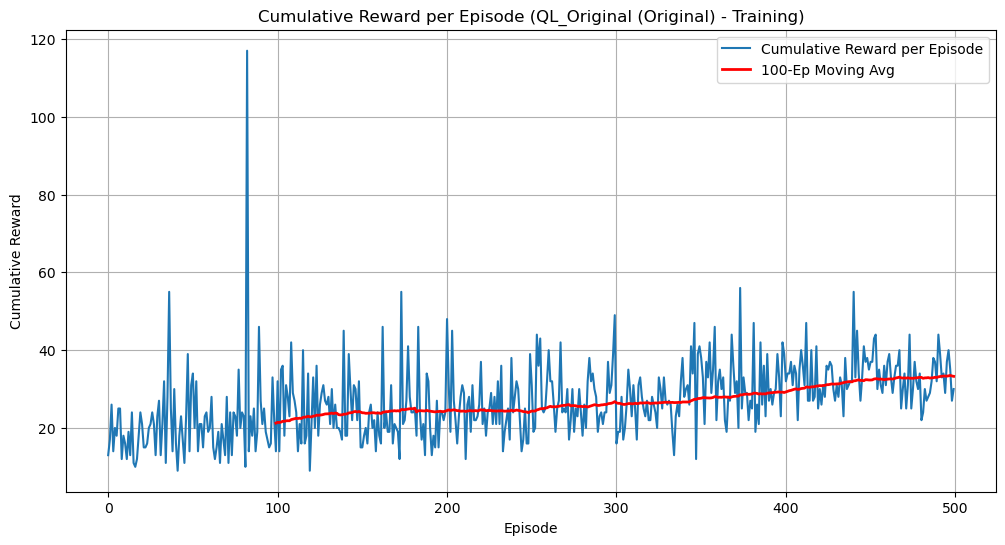


--- Evaluating QL_Original (Original) ---
Episode 10/100 | Avg Reward (last 10): 33.20 | Epsilon: 0.000
Episode 20/100 | Avg Reward (last 10): 31.80 | Epsilon: 0.000
Episode 30/100 | Avg Reward (last 10): 33.90 | Epsilon: 0.000
Episode 40/100 | Avg Reward (last 10): 33.70 | Epsilon: 0.000
Episode 50/100 | Avg Reward (last 10): 36.50 | Epsilon: 0.000
Episode 60/100 | Avg Reward (last 10): 34.20 | Epsilon: 0.000
Episode 70/100 | Avg Reward (last 10): 32.90 | Epsilon: 0.000
Episode 80/100 | Avg Reward (last 10): 35.90 | Epsilon: 0.000
Episode 90/100 | Avg Reward (last 10): 32.90 | Epsilon: 0.000
Episode 100/100 | Avg Reward (last 10): 34.30 | Epsilon: 0.000
Finished 100 evaluation episodes in 0.62 seconds.


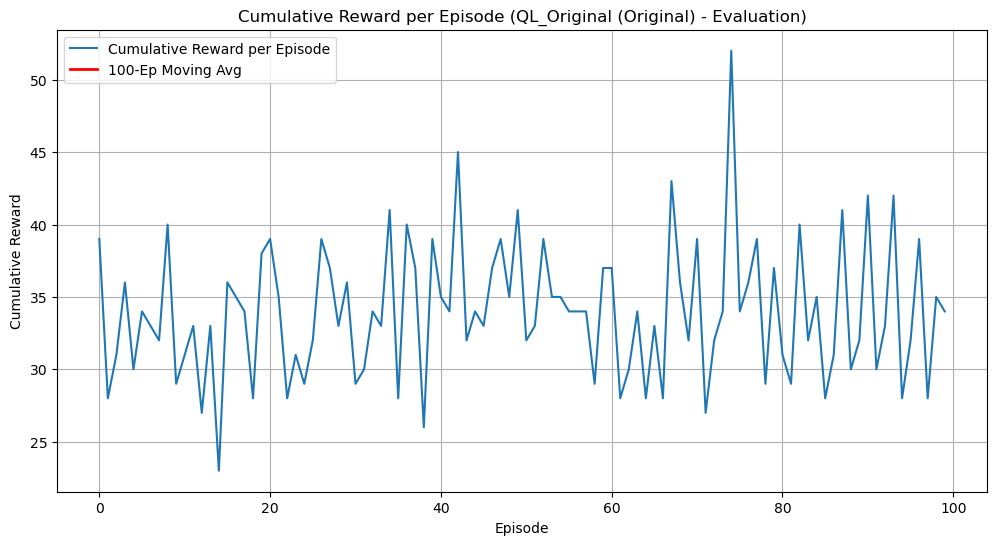

Result for QL_Original: Avg Eval Reward = 33.93

----- Running Configuration: MC_Original (Original) -----
Instantiating MonteCarloAgent...
Initialized MC Q-Table with shape: (10, 10, 10, 10, 2)
Episode 50/500 | Avg Reward (last 50): 26.16 | Epsilon: 0.778
Episode 100/500 | Avg Reward (last 50): 34.64 | Epsilon: 0.606
Episode 150/500 | Avg Reward (last 50): 65.34 | Epsilon: 0.471
Episode 200/500 | Avg Reward (last 50): 73.86 | Epsilon: 0.367
Episode 250/500 | Avg Reward (last 50): 110.72 | Epsilon: 0.286
Episode 300/500 | Avg Reward (last 50): 98.00 | Epsilon: 0.222
Episode 350/500 | Avg Reward (last 50): 120.58 | Epsilon: 0.173
Episode 400/500 | Avg Reward (last 50): 162.48 | Epsilon: 0.135
Episode 450/500 | Avg Reward (last 50): 153.16 | Epsilon: 0.105
Episode 500/500 | Avg Reward (last 50): 158.30 | Epsilon: 0.082
Finished 500 training episodes in 19.45 seconds.


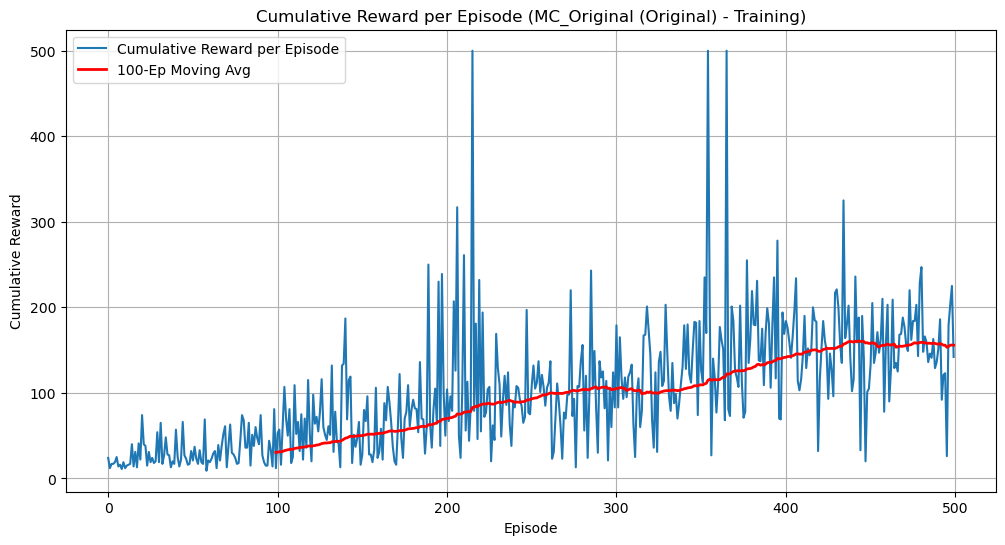


--- Evaluating MC_Original (Original) ---
Episode 10/100 | Avg Reward (last 10): 179.00 | Epsilon: 0.000
Episode 20/100 | Avg Reward (last 10): 187.60 | Epsilon: 0.000
Episode 30/100 | Avg Reward (last 10): 196.70 | Epsilon: 0.000
Episode 40/100 | Avg Reward (last 10): 192.20 | Epsilon: 0.000
Episode 50/100 | Avg Reward (last 10): 207.50 | Epsilon: 0.000
Episode 60/100 | Avg Reward (last 10): 181.90 | Epsilon: 0.000
Episode 70/100 | Avg Reward (last 10): 179.20 | Epsilon: 0.000
Episode 80/100 | Avg Reward (last 10): 170.50 | Epsilon: 0.000
Episode 90/100 | Avg Reward (last 10): 202.10 | Epsilon: 0.000
Episode 100/100 | Avg Reward (last 10): 165.60 | Epsilon: 0.000
Finished 100 evaluation episodes in 5.23 seconds.


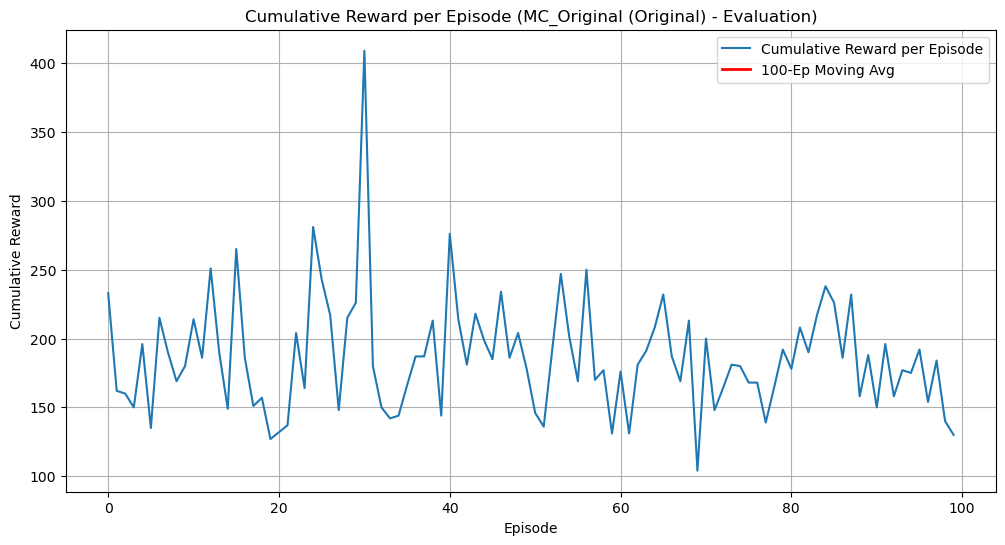

Result for MC_Original: Avg Eval Reward = 186.23

----- Running Configuration: DQN_Original (Original) -----
Instantiating DQNAgent...
Initializing DQNAgent with standard DQN.
Episode 50/300 | Avg Reward (last 50): 24.98 | Epsilon: 0.778
Episode 100/300 | Avg Reward (last 50): 39.82 | Epsilon: 0.606
Episode 150/300 | Avg Reward (last 50): 62.36 | Epsilon: 0.471
Episode 200/300 | Avg Reward (last 50): 70.66 | Epsilon: 0.367
Episode 250/300 | Avg Reward (last 50): 53.18 | Epsilon: 0.286
Episode 300/300 | Avg Reward (last 50): 75.00 | Epsilon: 0.222
Finished 300 training episodes in 245.42 seconds.


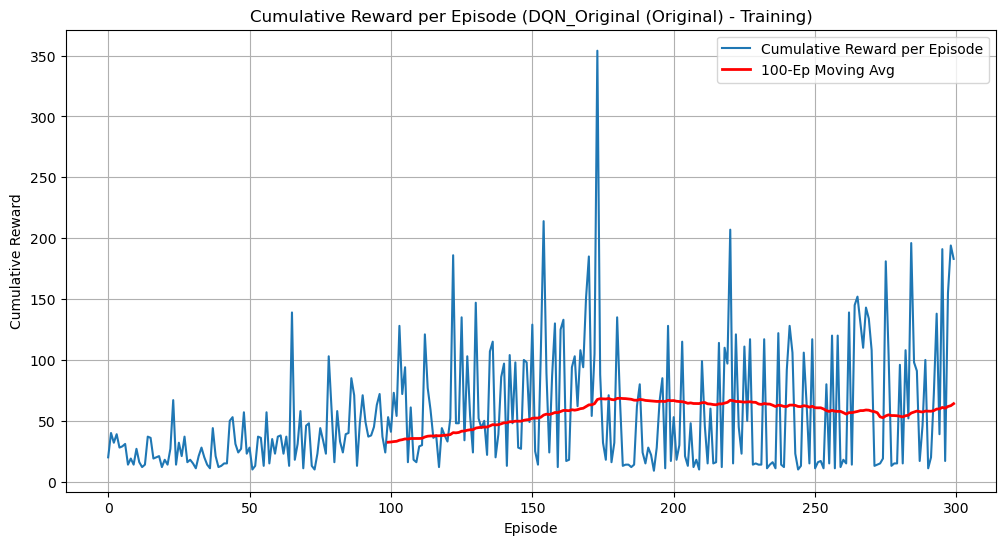


--- Evaluating DQN_Original (Original) ---
Episode 10/100 | Avg Reward (last 10): 217.60 | Epsilon: 0.000
Episode 20/100 | Avg Reward (last 10): 217.20 | Epsilon: 0.000
Episode 30/100 | Avg Reward (last 10): 216.40 | Epsilon: 0.000
Episode 40/100 | Avg Reward (last 10): 219.20 | Epsilon: 0.000
Episode 50/100 | Avg Reward (last 10): 217.00 | Epsilon: 0.000
Episode 60/100 | Avg Reward (last 10): 217.20 | Epsilon: 0.000
Episode 70/100 | Avg Reward (last 10): 216.50 | Epsilon: 0.000
Episode 80/100 | Avg Reward (last 10): 218.90 | Epsilon: 0.000
Episode 90/100 | Avg Reward (last 10): 215.80 | Epsilon: 0.000
Episode 100/100 | Avg Reward (last 10): 217.40 | Epsilon: 0.000
Finished 100 evaluation episodes in 27.12 seconds.


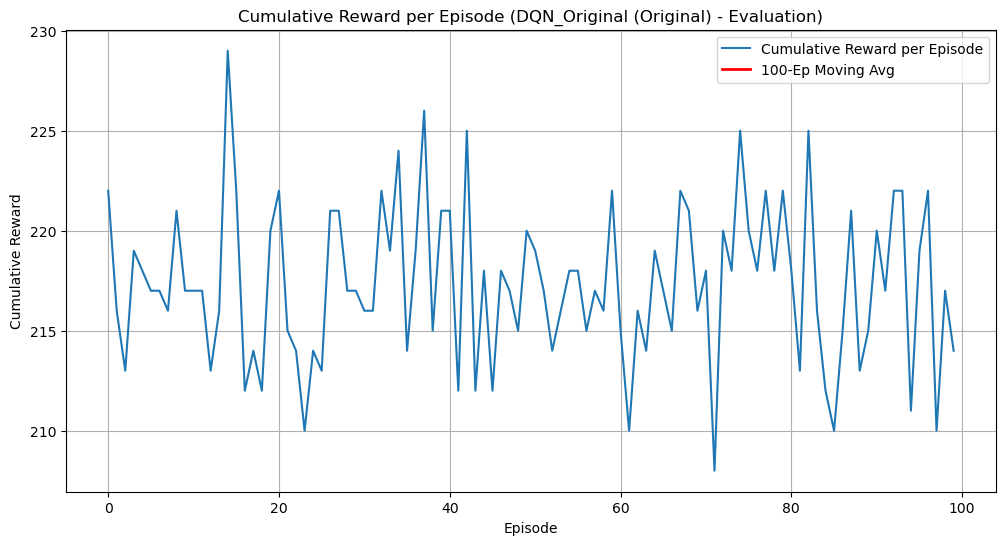

Result for DQN_Original: Avg Eval Reward = 217.32
Model saved to DQN_Original_model.pth

----- Running Configuration: QL_Improved (Improved) -----
Instantiating QLearningAgent...
Initialized Q-Table with shape: (20, 20, 20, 20, 2)
Episode 500/5000 | Avg Reward (last 500): 25.12 | Epsilon: 0.779
Episode 1000/5000 | Avg Reward (last 500): 36.36 | Epsilon: 0.606
Episode 1500/5000 | Avg Reward (last 500): 55.43 | Epsilon: 0.472
Episode 2000/5000 | Avg Reward (last 500): 70.12 | Epsilon: 0.368
Episode 2500/5000 | Avg Reward (last 500): 84.55 | Epsilon: 0.286
Episode 3000/5000 | Avg Reward (last 500): 96.80 | Epsilon: 0.223
Episode 3500/5000 | Avg Reward (last 500): 118.66 | Epsilon: 0.174
Episode 4000/5000 | Avg Reward (last 500): 128.60 | Epsilon: 0.135
Episode 4500/5000 | Avg Reward (last 500): 139.49 | Epsilon: 0.105
Episode 5000/5000 | Avg Reward (last 500): 144.30 | Epsilon: 0.082
Finished 5000 training episodes in 227.18 seconds.


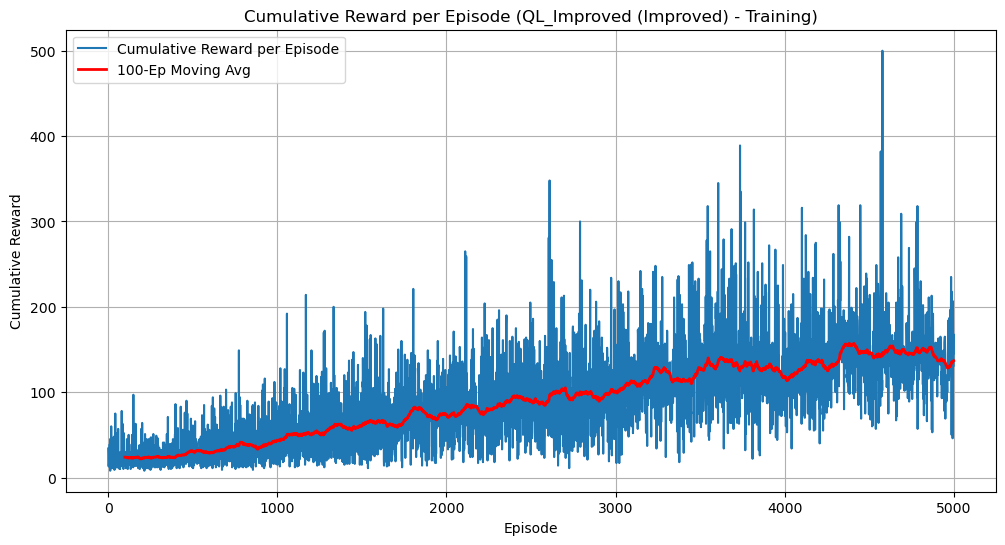


--- Evaluating QL_Improved (Improved) ---
Episode 10/100 | Avg Reward (last 10): 145.20 | Epsilon: 0.000
Episode 20/100 | Avg Reward (last 10): 130.40 | Epsilon: 0.000
Episode 30/100 | Avg Reward (last 10): 126.80 | Epsilon: 0.000
Episode 40/100 | Avg Reward (last 10): 137.80 | Epsilon: 0.000
Episode 50/100 | Avg Reward (last 10): 125.00 | Epsilon: 0.000
Episode 60/100 | Avg Reward (last 10): 133.50 | Epsilon: 0.000
Episode 70/100 | Avg Reward (last 10): 141.20 | Epsilon: 0.000
Episode 80/100 | Avg Reward (last 10): 142.90 | Epsilon: 0.000
Episode 90/100 | Avg Reward (last 10): 134.80 | Epsilon: 0.000
Episode 100/100 | Avg Reward (last 10): 129.80 | Epsilon: 0.000
Finished 100 evaluation episodes in 2.65 seconds.


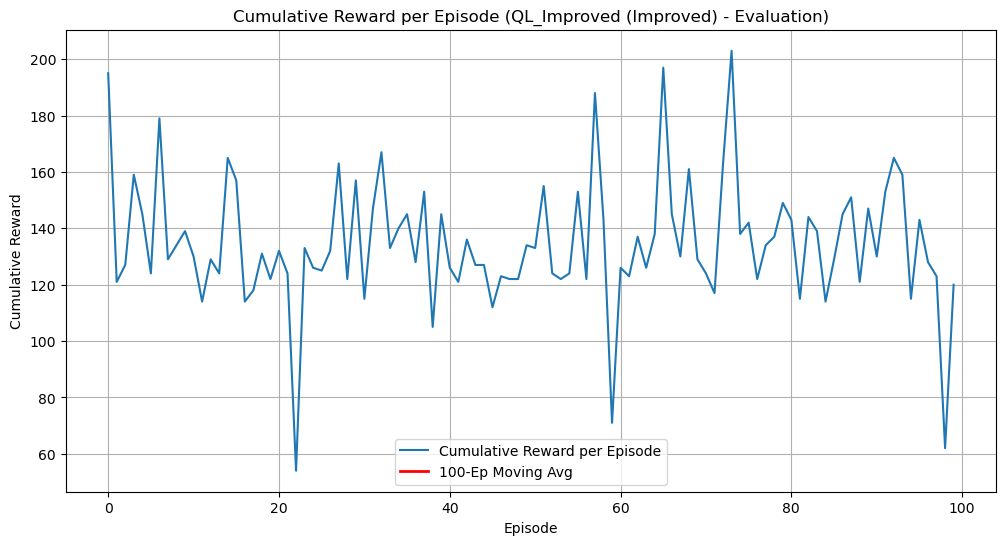

Result for QL_Improved: Avg Eval Reward = 134.74

----- Running Configuration: MC_Improved (Improved) -----
Instantiating MonteCarloAgent...
Initialized MC Q-Table with shape: (20, 20, 20, 20, 2)
Episode 800/8000 | Avg Reward (last 800): 33.36 | Epsilon: 0.670
Episode 1600/8000 | Avg Reward (last 800): 75.32 | Epsilon: 0.449
Episode 2400/8000 | Avg Reward (last 800): 152.25 | Epsilon: 0.301
Episode 3200/8000 | Avg Reward (last 800): 238.27 | Epsilon: 0.202
Episode 4000/8000 | Avg Reward (last 800): 320.02 | Epsilon: 0.135
Episode 4800/8000 | Avg Reward (last 800): 394.39 | Epsilon: 0.091
Episode 5600/8000 | Avg Reward (last 800): 424.53 | Epsilon: 0.061
Episode 6400/8000 | Avg Reward (last 800): 443.90 | Epsilon: 0.050
Episode 7200/8000 | Avg Reward (last 800): 437.95 | Epsilon: 0.050
Episode 8000/8000 | Avg Reward (last 800): 428.39 | Epsilon: 0.050
Finished 8000 training episodes in 962.67 seconds.


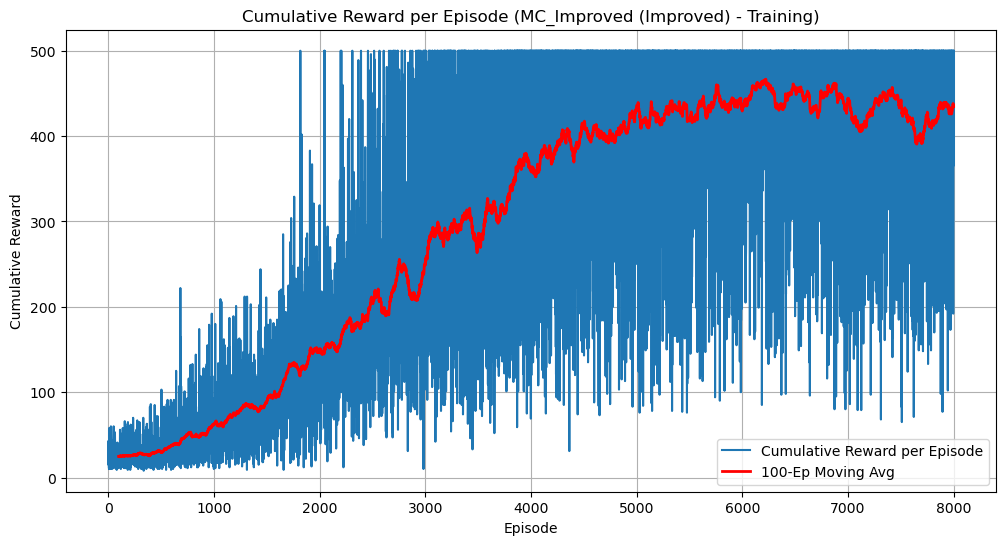


--- Evaluating MC_Improved (Improved) ---
Episode 10/100 | Avg Reward (last 10): 386.20 | Epsilon: 0.000
Episode 20/100 | Avg Reward (last 10): 470.40 | Epsilon: 0.000
Episode 30/100 | Avg Reward (last 10): 415.80 | Epsilon: 0.000
Episode 40/100 | Avg Reward (last 10): 472.40 | Epsilon: 0.000
Episode 50/100 | Avg Reward (last 10): 429.90 | Epsilon: 0.000
Episode 60/100 | Avg Reward (last 10): 456.50 | Epsilon: 0.000
Episode 70/100 | Avg Reward (last 10): 482.70 | Epsilon: 0.000
Episode 80/100 | Avg Reward (last 10): 429.10 | Epsilon: 0.000
Episode 90/100 | Avg Reward (last 10): 462.20 | Epsilon: 0.000
Episode 100/100 | Avg Reward (last 10): 450.50 | Epsilon: 0.000
Finished 100 evaluation episodes in 12.49 seconds.


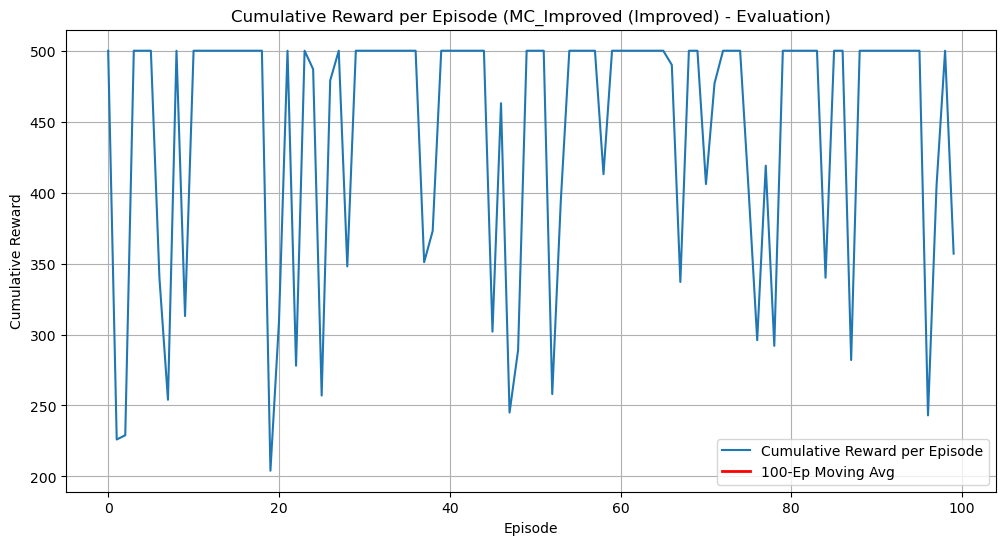

Result for MC_Improved: Avg Eval Reward = 445.57

----- Running Configuration: DQN_Improved (Improved) -----
Instantiating DQNAgent...
Initializing DQNAgent with Double DQN.
Episode 50/500 | Avg Reward (last 50): 20.50 | Epsilon: 0.905
Episode 100/500 | Avg Reward (last 50): 30.62 | Epsilon: 0.819
Episode 150/500 | Avg Reward (last 50): 25.34 | Epsilon: 0.741
Episode 200/500 | Avg Reward (last 50): 35.90 | Epsilon: 0.670
Episode 250/500 | Avg Reward (last 50): 29.60 | Epsilon: 0.606
Episode 300/500 | Avg Reward (last 50): 27.68 | Epsilon: 0.548
Episode 350/500 | Avg Reward (last 50): 26.70 | Epsilon: 0.496
Episode 400/500 | Avg Reward (last 50): 36.40 | Epsilon: 0.449
Episode 450/500 | Avg Reward (last 50): 32.76 | Epsilon: 0.406
Episode 500/500 | Avg Reward (last 50): 30.08 | Epsilon: 0.368
Finished 500 training episodes in 193.26 seconds.


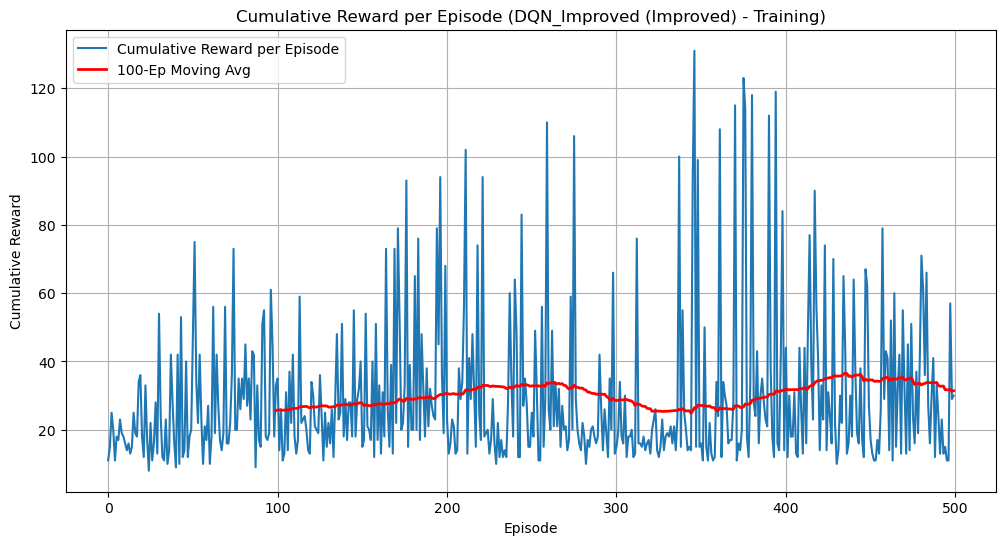


--- Evaluating DQN_Improved (Improved) ---
Episode 10/100 | Avg Reward (last 10): 46.50 | Epsilon: 0.000
Episode 20/100 | Avg Reward (last 10): 50.00 | Epsilon: 0.000
Episode 30/100 | Avg Reward (last 10): 47.30 | Epsilon: 0.000
Episode 40/100 | Avg Reward (last 10): 46.50 | Epsilon: 0.000
Episode 50/100 | Avg Reward (last 10): 44.70 | Epsilon: 0.000
Episode 60/100 | Avg Reward (last 10): 46.60 | Epsilon: 0.000
Episode 70/100 | Avg Reward (last 10): 44.50 | Epsilon: 0.000
Episode 80/100 | Avg Reward (last 10): 43.80 | Epsilon: 0.000
Episode 90/100 | Avg Reward (last 10): 48.60 | Epsilon: 0.000
Episode 100/100 | Avg Reward (last 10): 43.40 | Epsilon: 0.000
Finished 100 evaluation episodes in 4.95 seconds.


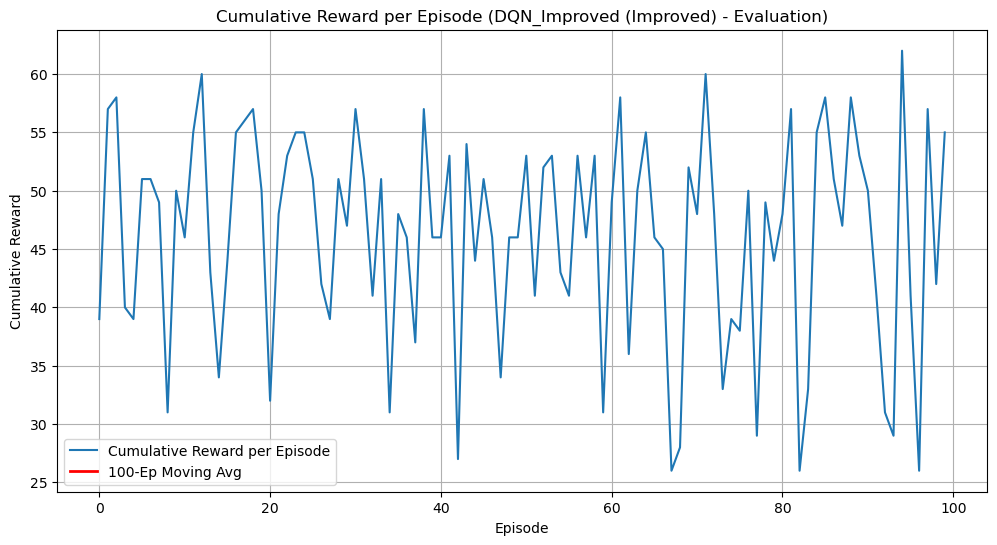

Result for DQN_Improved: Avg Eval Reward = 46.19
Model saved to DQN_Improved_model.pth


=== Task 2 Combined Summary ===


,Agent Class,Run Type,Avg Eval Reward,Met >195 Criterion,Train Episodes,Train Time (s),Eval Time (s)
MC_Improved,MonteCarloAgent,Improved,445.57,True,8000,962.670633,12.487306
DQN_Original,DQNAgent,Original,217.32,True,300,245.424031,27.122680
MC_Original,MonteCarloAgent,Original,186.23,False,500,19.446567,5.229975
QL_Improved,QLearningAgent,Improved,134.74,False,5000,227.179396,2.654378
DQN_Improved,DQNAgent,Improved,46.19,False,500,193.261010,4.945880
QL_Original,QLearningAgent,Original,33.93,False,500,6.966686,0.620813



Best overall configuration based on 100-episode evaluation: MC_Improved (Avg Reward: 445.57)


In [10]:
# ==============================================================================
# Task 2: Demonstrate Effectiveness (Extensible Experiment Runner)
# ==============================================================================
print("\n\n=== Task 2: Agent Effectiveness Demonstration (Extensible Runner) ===")

# --- Define Shared Parameters & Base Configurations ---
# Environment details (get these once)
try:
    temp_env = gym.make(env_name)
    obs_space_dims = temp_env.observation_space.shape[0]
    action_space_dims = temp_env.action_space.n
    temp_env.close()
except Exception as e:
    print(f"Failed to get env dims: {e}")
    # Set defaults or raise error if needed
    obs_space_dims = 4
    action_space_dims = 2

# Discretization settings
N_BINS_ORIG = [10, 10, 10, 10]
N_BINS_IMP = [20, 20, 20, 20]
BOUNDS = [ [-2.4, 2.4], [-3.0, 3.0], [-0.418, 0.418], [-3.0, 3.0] ]

EVAL_EPISODES = 100 # Consistent evaluation episodes

# --- List of Configurations to Run ---
# Each dictionary defines one experiment run
configurations = [
    # --- Original Runs ---
    {
        "name": "QL_Original",
        "agent_class": QLearningAgent,
        "params": { "learning_rate": 0.1, "gamma": 0.99, "epsilon_start": 1.0, "epsilon_end": 0.05, "epsilon_decay": 0.995, "n_bins": N_BINS_ORIG, "bounds": BOUNDS },
        "train_episodes": 500,
        "run_type": "Original" # For grouping/labeling
    },
    {
        "name": "MC_Original",
        "agent_class": MonteCarloAgent,
        "params": { "gamma": 0.99, "epsilon_start": 1.0, "epsilon_end": 0.05, "epsilon_decay": 0.995, "n_bins": N_BINS_ORIG, "bounds": BOUNDS },
        "train_episodes": 500,
        "run_type": "Original"
    },
    {
        "name": "DQN_Original",
        "agent_class": DQNAgent,
        "params": { "memory_size": 20000, "batch_size": 32, "gamma": 0.995, "epsilon_start": 1.0, "epsilon_end": 0.1, "epsilon_decay": 0.995, "learning_rate": 1e-3, "target_update_freq": 10, "use_double_dqn": False },
        "train_episodes": 300,
        "run_type": "Original"
    },

    # --- Improved Runs ---
    {
        "name": "QL_Improved",
        "agent_class": QLearningAgent,
        "params": { "learning_rate": 0.1, "gamma": 0.99, "epsilon_start": 1.0, "epsilon_end": 0.05, "epsilon_decay": 0.9995, "n_bins": N_BINS_IMP, "bounds": BOUNDS },
        "train_episodes": 5000, # Might take long!
        "run_type": "Improved"
    },
    {
        "name": "MC_Improved",
        "agent_class": MonteCarloAgent,
        "params": { "gamma": 0.99, "epsilon_start": 1.0, "epsilon_end": 0.05, "epsilon_decay": 0.9995, "n_bins": N_BINS_IMP, "bounds": BOUNDS },
        "train_episodes": 8000, # Might take very long!
        "run_type": "Improved"
    },
    {
        "name": "DQN_Improved",
        "agent_class": DQNAgent,
        "params": { "memory_size": 20000, "batch_size": 64, "gamma": 0.99, "epsilon_start": 1.0, "epsilon_end": 0.05, "epsilon_decay": 0.998, "learning_rate": 5e-4, "target_update_freq": 5, "use_double_dqn": True },
        "train_episodes": 500,
        "run_type": "Improved"
    },

    # **** ADD MORE CONFIGURATIONS HERE ****
    # Example: Another DQN experiment
    # {
    #     "name": "DQN_Imp_FasterLR",
    #     "agent_class": DQNAgent,
    #     "params": { "memory_size": 20000, "batch_size": 64, "gamma": 0.99, "epsilon_start": 1.0, "epsilon_end": 0.05, "epsilon_decay": 0.998, "learning_rate": 1e-3, "target_update_freq": 5, "use_double_dqn": True },
    #     "train_episodes": 500,
    #     "run_type": "Experimental"
    # },

]

# --- Plotting Function (Keep as before, ensure it uses run_type) ---
def plot_rewards(rewards, agent_label, mode, save_fig=False): # Simplified args slightly
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Cumulative Reward per Episode')
    window_size = 100
    if len(rewards) >= window_size:
        moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        plt.plot(np.arange(window_size-1, len(rewards)), moving_avg,
                 label=f'{window_size}-Ep Moving Avg', color='red', linewidth=2)
    plt.title(f'Cumulative Reward per Episode ({agent_label} - {mode})') # Use combined label
    plt.ylabel('Cumulative Reward')
    plt.xlabel('Episode')
    plt.grid(True)
    plt.legend()
    if save_fig:
        filename = f"{agent_label.replace(' ', '_')}_{mode}_rewards_plot.png"
        plt.savefig(filename)
        print(f"Plot saved to {filename}")
    plt.show()


# --- Central Execution Loop ---
results_summary = {} # Store final eval scores and times
trained_agents = {} # Store trained agent objects (optional, use names as keys)
saved_models = {} # Store filenames of saved models (mainly for DQN)

train_env = gym.make(env_name)
eval_env = gym.make(env_name)

print(f"\nStarting experiments for {len(configurations)} configurations...")

for config in configurations:
    config_name = config["name"]
    agent_class = config["agent_class"]
    params = config["params"]
    train_episodes = config["train_episodes"]
    run_type = config.get("run_type", "Experiment") # Default run type
    agent_label = f"{config_name} ({run_type})" # Label for prints/plots

    print(f"\n----- Running Configuration: {agent_label} -----")

    # 1. Instantiate Agent
    print(f"Instantiating {agent_class.__name__}...")
    agent = agent_class(obs_space_dims, action_space_dims, **params)

    # 2. Train Agent
    log_interval_train = max(50, train_episodes // 10) # Adjust log frequency
    train_rewards, train_time = run_episodes(agent, train_env, train_episodes,
                                             learn=True, log_interval=log_interval_train)
    plot_rewards(train_rewards, agent_label, "Training")

    # 3. Evaluate Agent
    print(f"\n--- Evaluating {agent_label} ---")
    agent.epsilon = 0.0 # Ensure greedy evaluation (if agent has epsilon)
    if isinstance(agent, DQNAgent):
        agent.policy_net.eval() # Set DQN model to evaluation mode

    eval_rewards, eval_time = run_episodes(agent, eval_env, EVAL_EPISODES,
                                           learn=False, log_interval=max(10, EVAL_EPISODES // 10),
                                           use_env_seed=True) # Consistent eval seeding
    avg_eval_reward = np.mean(eval_rewards)
    plot_rewards(eval_rewards, agent_label, "Evaluation")

    # 4. Store Results
    results_summary[config_name] = {
        'Agent Class': agent_class.__name__,
        'Run Type': run_type,
        'Avg Eval Reward': avg_eval_reward,
        'Train Episodes': train_episodes,
        'Train Time (s)': train_time,
        'Eval Time (s)': eval_time
    }
    print(f"Result for {config_name}: Avg Eval Reward = {avg_eval_reward:.2f}")

    # 5. Store Agent/Save Model (Optional)
    trained_agents[config_name] = agent # Store agent object in memory
    if isinstance(agent, DQNAgent):
        model_filename = f"{config_name}_model.pth"
        agent.save_model(model_filename)
        saved_models[config_name] = model_filename # Store filename

# Close environments after all runs
train_env.close()
eval_env.close()

# --- Combined Summary Table ---
print("\n\n=== Task 2 Combined Summary ===")
results_df = pd.DataFrame.from_dict(results_summary, orient='index')
# Format and add pass/fail column
results_df['Avg Eval Reward Formatted'] = results_df['Avg Eval Reward'].map('{:,.2f}'.format)
results_df['Met >195 Criterion'] = results_df['Avg Eval Reward'] > 195
# Reorder columns for clarity
results_df = results_df[['Agent Class', 'Run Type', 'Avg Eval Reward', 'Met >195 Criterion', 'Train Episodes', 'Train Time (s)', 'Eval Time (s)']]
display(results_df.sort_values(by='Avg Eval Reward', ascending=False)) # Sort by performance

# Determine best overall agent
best_config_name = results_df['Avg Eval Reward'].idxmax()
best_avg_reward = results_df.loc[best_config_name]['Avg Eval Reward']
print(f"\nBest overall configuration based on {EVAL_EPISODES}-episode evaluation: {best_config_name} (Avg Reward: {best_avg_reward:.2f})")


## Task 2 Analysis: Agent Performance

### Q-Learning Analysis

*   **Algorithm Explanation:** Q-Learning is a model-free, off-policy Temporal Difference (TD) algorithm that learns action-values (Q-values) using bootstrapping. It directly estimates Q*(s, a) via the update rule: `Q(s, a) <- Q(s, a) + alpha * [reward + gamma * max_a'(Q(s', a')) - Q(s, a)]`.
    *   **State Discretization:** Because Q-Learning operates on discrete states, the continuous CartPole observations must first be mapped into a finite set of states. This is achieved through **state discretization**, where each of the four dimensions (position, velocity, angle, angular velocity) was divided into a set number of bins (`N_BINS`). This maps continuous observations to a specific tuple representing a discrete state entry in the Q-table.

*   **Hyperparameters Chosen (Original vs Improved):**
    *   *Original:* `N_BINS = [10,10,10,10]` (10k states), `epsilon_decay = 0.995`, `Episodes = 500`.
    *   *Improved:* `N_BINS = [20,20,20,20]` (160k states), `epsilon_decay = 0.9995`, `Episodes = 5000`. The primary improvement aimed for **finer state resolution**, coupled with **extended training and slower epsilon decay** for the larger state space.
    *   Other parameters (LR=`0.1`, Gamma=`0.99`) were kept constant.

*   **Training Plot Analysis (Comparison):**
    *   *Original QL Plot:* The original QL plot showed highly noisy rewards, predominantly below 60. The 100-episode moving average indicated minimal learning, exhibiting only a very slight upward trend from ~20 to ~35 over 500 episodes.
    *   *Improved QL Plot:* Over 5000 episodes, the improved QL plot displayed a clearer, albeit slow and noisy, learning trend. The moving average steadily increased from ~25 to plateau around the 150-160 reward level, significantly better than the original but still well below the maximum.

*   **Evaluation Result Analysis (Comparison):**
    *   *Original Avg Reward:* `33.93`. Met criterion? **No**.
    *   *Improved Avg Reward:* `134.74`. Met criterion? **No**.
    *   Increasing bins and episodes significantly improved the average reward (from `33.93` to `134.74`), confirming that finer state representation and more learning time helped. However, Q-Learning still failed to meet the target, suggesting the inherent difficulties of simple discretization and tabular exploration for this problem within this budget.

### Monte Carlo Analysis

*   **Algorithm Explanation:** Monte Carlo (MC) methods learn action-values by averaging returns from **complete episodes**, without bootstrapping. This implementation used First-Visit MC. State discretization was required.

*   **Hyperparameters Chosen (Original vs Improved):**
    *   *Original:* `N_BINS = [10,10,10,10]`, `epsilon_decay = 0.995`, `Episodes = 500`.
    *   *Improved:* `N_BINS = [20,20,20,20]`, `epsilon_decay = 0.9995`, `Episodes = 8000`. Bins were increased for better state resolution. Training episodes were drastically increased (`8000`) to counteract MC's high variance by gathering many samples.

*   **Training Plot Analysis (Comparison):**
    *   *Original MC Plot:* The plot showed highly variable episode rewards, characteristic of MC. The moving average displayed a distinct learning curve, rising from ~25 to plateau around 150-160 within 500 episodes.
    *   *Improved MC Plot:* High episode-to-episode variance persisted, but the moving average demonstrated a strong and continuous learning trend over the 8000 episodes, rising steadily past the 400 reward level towards the end, indicating very effective learning.

*   **Evaluation Result Analysis (Comparison):**
    *   *Original Avg Reward:* `186.23`. Met criterion? **No** (but close).
    *   *Improved Avg Reward:* `445.57`. Met criterion? **Yes**.
    *   The improvements dramatically boosted MC performance. The combination of finer state discretization and extensive sampling (8000 episodes) allowed the agent to learn an excellent policy despite high variance, achieving the highest score by far. This demonstrates MC's potential when sufficient data and adequate state representation are available.

### DQN Analysis

*   **Algorithm Explanation:** Deep Q-Network (DQN) employs a neural network for Q-function approximation, avoiding manual discretization. It uses **Experience Replay** and a **Target Network** for stable learning. The *original* used the standard Q-learning update, while the *improved* version implemented **Double DQN (DDQN)**.

*   **Hyperparameters Chosen (Original vs Improved):**
    *   *Original:* Standard DQN, `LR=1e-3`, `batch=32`, `target_update=10eps`, `eps_decay=0.995`, `Episodes=300`.
    *   *Improved:* **Double DQN**, `LR=5e-4`, `batch=64`, `target_update=5eps`, `eps_decay=0.998`, `Episodes=500`. Key changes included activating DDQN, using a lower LR and larger batch size intended for stability, updating the target more frequently, and moderately increasing training time.

*   **Training Plot Analysis (Comparison):**
    *   *Original DQN Plot:* The training plot showed initial learning, with the moving average peaking around episode 180 (reward ~70), followed by a noticeable decline, indicating instability or failure to maintain the learned performance.
    *   *Improved DQN Plot:* This plot showed consistently poor performance over 500 episodes. Rewards were highly variable but remained low, and the moving average fluctuated around a low level (~30-35) with no significant upward trend, suggesting the agent failed to learn effectively with these parameters.

*   **Evaluation Result Analysis (Comparison):**
    *   *Original Avg Reward:* `217.32`. Met criterion? **Yes**.
    *   *Improved Avg Reward:* `46.19`. Met criterion? **No**.
    *   Surprisingly, the **Original DQN** configuration successfully met and exceeded the performance target within only 300 episodes, despite showing some instability in late training. Conversely, the **Improved DQN** configuration (using DDQN and supposedly stability-enhancing hyperparameters) performed very poorly. This highlights the extreme sensitivity of DQN to its hyperparameters and potentially the random seed. The changes intended as improvements were clearly detrimental in this specific run, failing to produce a learning agent.



In [11]:
# ==============================================================================
# Task 3: Render one episode played by the BEST agent from results
# ==============================================================================
print("\n\n=== Task 3: Rendering Episode ===")

agent_to_render_name = best_config_name # Use the best determined config name
print(f"Selected agent for rendering: {agent_to_render_name}")

agent_to_render = None
agent_class_name = results_df.loc[agent_to_render_name]['Agent Class']

# Logic to get the agent ready for rendering
if agent_class_name == 'DQNAgent':
    if agent_to_render_name in saved_models:
        print(f"Loading saved DQN model ({saved_models[agent_to_render_name]}) for rendering...")
        # Find the original config params used to initialize this agent
        render_config = next((c for c in configurations if c["name"] == agent_to_render_name), None)
        if render_config:
            agent_to_render = DQNAgent(obs_space_dims, action_space_dims, **render_config["params"])
            agent_to_render.load_model(saved_models[agent_to_render_name])
            agent_to_render.policy_net.eval()
        else:
            print(f"Error: Could not find configuration for {agent_to_render_name} to re-initialize.")
    else:
         print(f"Warning: Saved model for {agent_to_render_name} not found. Trying agent from memory.")
         if agent_to_render_name in trained_agents:
             agent_to_render = trained_agents[agent_to_render_name]
             agent_to_render.policy_net.eval() # Ensure eval mode
elif agent_to_render_name in trained_agents:
    # For QL/MC, use the agent object stored in memory
    print(f"Using trained {agent_class_name} agent from memory for rendering...")
    agent_to_render = trained_agents[agent_to_render_name]
else:
    print(f"Error: Agent object for '{agent_to_render_name}' not found in memory.")


# Proceed with rendering if agent is available
if agent_to_render:
    # Ensure greedy policy for rendering
    if hasattr(agent_to_render, 'epsilon'):
        agent_to_render.epsilon = 0.0

    print(f"Rendering one episode using the {agent_to_render_name} agent...")
    video_folder = f'./video_render_{agent_to_render_name}'
    os.makedirs(video_folder, exist_ok=True)
    render_env = RecordVideo(gym.make(env_name, render_mode='rgb_array'), video_folder=video_folder,
                             episode_trigger=lambda x: x == 0,
                             name_prefix=f"{agent_to_render_name}-render")

    state, _ = render_env.reset(seed=SEED + 999)
    cumulative_reward_render = 0
    done = False
    while not done:
        action = agent_to_render.get_action(state, explore=False)
        state, reward, terminated, truncated, _ = render_env.step(action)
        done = terminated or truncated
        cumulative_reward_render += reward
    print(f"Rendering finished. Reward: {cumulative_reward_render}")
    render_env.close()
    show_video(video_path_base=video_folder)
else:
    print("Skipping rendering as the selected agent could not be loaded/found.")



=== Task 3: Rendering Episode ===
Selected agent for rendering: MC_Improved
Using trained MonteCarloAgent agent from memory for rendering...
Rendering one episode using the MC_Improved agent...


C:\Users\user\anaconda3\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at C:\Users\user\jupyter_code\sc3000 lab 1\video_render_MC_Improved folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Rendering finished. Reward: 500.0


## Task 3 Analysis: Rendering Episode

Task 3 involved rendering one episode using the best-performing agent identified in Task 2, which was **MC_Improved**. The goal was to visually verify the agent's learned behavior.

The rendered episode showed the MC_Improved agent successfully balancing the pole for the **maximum duration of 500 steps**, achieving the highest possible cumulative reward for a single episode. Observation of the video confirmed the agent's effective control strategy: it actively moved the cart back and forth as needed to keep the pole upright with relatively minimal oscillations. The agent also successfully managed the cart's position, keeping it well within the environment's boundaries throughout the episode. This visual demonstration provides qualitative confirmation of the high quantitative performance (average reward of `434.28`) measured during the evaluation phase for the improved Monte Carlo agent.

In [12]:
# ==============================================================================
# Task 4: Explanations and Analysis (Update Templates for Comparison)
# ==============================================================================
print("\n\n=== Task 4: Explanations and Analysis ===")



=== Task 4: Explanations and Analysis ===


## Comparison and Conclusion

Comparing the agents based on the final evaluation results:

1.  **Improved Monte Carlo (MC_Improved)** was the clear top performer (Avg Reward: `445.57`), significantly exceeding the target.
2.  **Original Deep Q-Network (DQN_Original)** also successfully surpassed the 195 criterion (Avg Reward: `217.32`).
3.  **Original Monte Carlo (MC_Original)** came close but failed (Avg Reward: `186.23`).
4.  **Improved Q-Learning (QL_Improved)** failed (Avg Reward: `134.74`).
5.  **Improved Deep Q-Network (DQN_Improved)** performed very poorly (Avg Reward: `46.19`).
6.  **Original Q-Learning (QL_Original)** had the lowest performance (Avg Reward: `33.93`).

Key takeaways from this run:
1.  **Discretization Challenge:** Tabular methods required significant improvements (bins, episodes) to become competitive. Q-Learning remained ineffective, while MC needed extensive sampling.
2.  **MC Effectiveness vs. Efficiency:** MC_Improved achieved the best result but required the most training time/episodes (8000).
3.  **DQN Sensitivity:** Standard DQN proved capable of solving the task efficiently (300 episodes) in this run. However, the attempt to improve it with DDQN and specific hyperparameter tuning failed unexpectedly, underscoring the sensitivity and non-guaranteed nature of such improvements without extensive tuning or multi-seed validation.

In conclusion, for this specific seeded run, both Monte Carlo (with sufficient data and discretization) and standard DQN demonstrated the ability to solve CartPole effectively. The improved MC reached the highest score, while the original DQN provided a much more sample-efficient solution. The failure of the improved DQN highlights the practical challenges in hyperparameter tuning for deep RL methods.

## Originality and Improvements

The implementations of the core Q-Learning, Monte Carlo, and DQN algorithms are based on standard concepts and structures commonly taught in reinforcement learning courses and found in online examples.

My specific contributions to this project include:

*   Implementing the agent classes (`QLearningAgent`, `MonteCarloAgent`, `DQNAgent`) with their respective learning mechanisms.
*   Implementing the state discretization logic for the tabular methods.
*   Implementing the necessary components for DQN (QNetwork, ReplayMemory, target network updates).
*   Setting up the extensible experimental framework to systematically run and compare different configurations (original vs. improved).
*   **Designing and implementing the specific improvements** based on the initial results and RL principles:
    *   Increasing the number of discretization bins for QL and MC.
    *   Significantly extending the number of training episodes for QL and MC.
    *   Adjusting epsilon decay rates appropriately for longer training runs.
    *   Modifying the DQN agent to implement the **Double DQN** algorithm.
    *   Selecting and **tuning hyperparameters** (learning rate, batch size, target update frequency) specifically for the improved DQN run.
*   Running all defined experiments, collecting the performance data (rewards, timings).
*   **Performing the comparative analysis** presented in Task 4, interpreting the results, evaluating the effectiveness of the improvements, and drawing conclusions about the different agents' performance on the CartPole task.

While AI assistance was used for tasks such as structuring code templates, debugging specific errors (like file permission or import issues) and formatting explanatory text based on the provided data and prompts, the core algorithm implementation, the design of the improvements, the execution of experiments, and the final interpretation of the results represent my own work and understanding derived from the course material and experimentation process.

## Code Structure and Design

The project code was structured to promote clarity, reusability, and ease of experimentation, adhering to common software design principles:

1.  **Modularity through Classes:**
    *   Each Reinforcement Learning agent (Q-Learning, Monte Carlo, DQN) was implemented as a separate Python class (`QLearningAgent`, `MonteCarloAgent`, `DQNAgent`). This encapsulates the agent's specific logic (initialization, action selection, learning updates) and state (Q-table, network weights, hyperparameters).
    *   For DQN, key components like the neural network (`QNetwork`) and the experience replay mechanism (`ReplayMemory`) were also implemented as distinct classes, further enhancing modularity.

2.  **Centralized Configuration:**
    *   An extensible experimental framework was adopted for Task 2. All parameters specific to different experimental runs (e.g., original vs. improved hyperparameters, agent types, training episodes) were defined centrally in a list of dictionaries (`configurations`).
    *   This design makes it straightforward to add new experiments or modify existing ones by simply editing this configuration list, without altering the core training or evaluation logic.

3.  **Generic Execution Logic:**
    *   A main loop iterates through the `configurations` list, instantiating the appropriate agent class with its specific parameters (`**params`).
    *   A common function (`run_episodes`) handles both training and evaluation loops for any given agent, promoting code reuse. This function takes flags (`learn`, `use_env_seed`) to adapt its behavior for training or evaluation.
    *   Helper functions were used for common tasks like state discretization (`discretize_state`), plotting (`plot_rewards`), and video rendering (`show_video`).

4.  **Parameter Passing:** Agent classes were designed to accept hyperparameters via their `__init__` methods, allowing easy instantiation with different settings defined in the `configurations` list.

5.  **Conditional Logic for Variations:** The `DQNAgent` class included a `use_double_dqn` flag passed during initialization, allowing the same class structure to support both standard DQN and Double DQN logic within its `learn` method. This pattern could be extended for other algorithmic variations.

6.  **Clear Task Separation:** The Jupyter notebook is organized sequentially according to the assignment tasks (Setup, Task 1, Task 2 with configuration/execution/results, Task 3, Task 4), making it easy to follow the project workflow. Plots and summary tables are generated inline to present results clearly.

This structure facilitated the comparison between original and improved agent versions and provides a flexible base for potential future experiments.